**Anurag Sharma (24AI91R01)**

## **Lab Assignment 1**

<font color='purple'>**K-NN regression**</font>

<font color='blue'>Description:</font> Neighbors-based regression can be used in cases where the data labels are continuous rather than discrete variables. The label assigned to a query point is computed based on the mean of the labels of its nearest neighbors.

<font color='blue'>scikit-learn implements two different neighbors regressors: </font>  
1. ***KNeighborsRegressor*** implements learning based on the K nearest neighbors of each query point, where K is an integer value specified by the user.
2. ***RadiusNeighborsRegressor*** implements learning based on the neighbors within a fixed radius of the query point, where is a floating-point value specified by the user.

<font color='red'>**NOTE**</font>

The basic nearest neighbors regression uses ```uniform weights:``` that is, each point in the local neighborhood contributes uniformly to the classification of a query point. Under some circumstances, it can be advantageous to ```weight points``` such that nearby points contribute more to the regression than faraway points. This can be accomplished through the ```weights keyword```. The default value, ```weights = 'uniform'```, assigns equal weights to all points. ```weights = 'distance'``` assigns weights proportional to the inverse of the distance from the query point.

**Alternatively, a user-defined function of the distance can be supplied, which will be used to compute the weights.**


### <font color='blue'>Objective: </font>

In this assignment, you will implement and evaluate a K-Nearest Neighbors (KNN) regression model using a toy dataset generated with scikit-learn. You will implement with scikit-learn's built-in KNN regression and analyze the performance.

#### Task - 1:
Dataset creation using make_regression of scikit-learn [Mark - 0]



In [311]:
# Creating regression dataset
# from sklearn.datasets import make_regression
# import pandas as pd

# # Creating a toy regression dataset with 5 features
# X_gen, y_gen = make_regression(n_samples=1000, n_features=5, noise=0.1, random_state=42)

# # Combine the features and target into one DataFrame
# df = pd.DataFrame(X_gen, columns=[f'Feature_{i}' for i in range(1, 6)])
# df['target'] = y_gen

# # Save the DataFrame to a CSV file
# df.to_csv('regression_dataset.csv', index=False)

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

In [313]:
df = pd.read_csv('https://raw.githubusercontent.com/Rekha215/Machine-Learning-Laboratory/main/regression_dataset.csv')
# df = pd.read_csv('regression_dataset.csv')
df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,target
0,2.056544,0.606851,0.482688,-1.130888,0.420094,74.905613
1,-0.799192,-0.645964,-0.182896,-0.482744,1.374876,-41.649588
2,1.076007,-0.796026,-0.751969,0.021312,-0.319054,-24.182866
3,-0.103255,-0.828497,1.489863,-1.643189,-1.600904,-87.094505
4,-2.063403,0.503252,-0.645572,-0.317350,-1.661083,-86.122029


In [314]:
X = df[df.columns.drop('target')].to_numpy()
Y = df[['target']].to_numpy()

In [315]:
# splitting data into train, test, and validation set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=4)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.30, random_state=4)

#### Task - 2:
Two K-NN regressor implementations (from scratch)
1. Average of K-nearest neighbors [Marks - 5]
2. Weighted average of k nearest neighbors, with weights being inverse of distances from the k neighbors [Marks - 5]

In [316]:
def minkowski_distance(x, y, p=2):
    return np.sum(np.abs(x - y) ** p) ** (1 / p)

class KNN:
    def __init__(self, k=3, weight='uniform', distance_metric='minkowski', p=2):
        self.k = k
        self.weight = weight
        self.distance_metric = distance_metric  # Add distance_metric parameter
        self.p = p  # Add p parameter for Minkowski distance

    def fit_knn(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def _compute_distance(self, x):
        if self.distance_metric == 'minkowski':
            distances = [minkowski_distance(x, x_train, p=self.p) for x_train in self.X_train]
        else:
            raise ValueError("Unsupported distance metric")
        return distances

    def predict_knn(self, X_test):

        predictions = []

        for x in tqdm(X_test):

            distances = self._compute_distance(x)   # distances from all points
            k_indices = np.argsort(distances)[:self.k]  # lowest distances
            k_distances = [distances[i] for i in k_indices]  # sorted_distances of K neighbors
            # k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            # print("K = ", k_nearest_labels)

            #Q1. Average of K-nearest neighbors
            if self.weight == 'uniform':
                prediction = np.mean(k_nearest_labels)
                predictions.append(prediction)

            #Q2. Weighted average of k nearest neighbors, with weights being inverse of distances from the k neighbors
            elif self.weight == 'distance':
                #k_distances = np.where(k_distances == 0, 1e-10, k_distances)        # to handle infinity value if distance = 0
                weights = [1/distance for distance in k_distances[:self.k]]
                prediction = np.dot(weights, k_nearest_labels) / np.sum(weights)     # Σ(wi*xi)/Σ(wi)
                # print(prediction)
                predictions.append(prediction)

            else:
                raise ValueError("Unsupported weight type")

        return predictions

#### Task - 3:
Plot regression metric (mean squared error) against different values of k ``` {3, 7, 11}``` and different distance measures ```{p=2, p=1, p=5}```and report the k value and distance measure combination that gave the best performance (lowest MSE) [Marks - 4]

Answer:
We use validation set to find the optimal values of k and p.

*   For Average, k=3, p=2, MSE = 362.643
*   For Distance, k=3, p=2, MSE = 349.165

In [317]:
k_values = [3, 7, 11]
p_values = [2, 1, 5]

In [318]:
class Metrics:
    def __init__(self, k_values, p_values, mse_values):
        self.k_values = k_values  # list of k values
        self.p_values = p_values  # list of p values
        self.mse_values = mse_values  # mse_values should be a dictionary

    def _find_best_metrics(self, mse_values):
        min_mse = float('inf')
        best_k = None
        best_p = None
        for k, values in mse_values.items():
            for p, mse in values:
                if mse < min_mse:
                    min_mse = mse
                    best_k = k
                    best_p = p
        print(f"K = {best_k} and distance measure (p) = {best_p} gave the best performance with Mean Square Error = {min_mse}")
        return best_k, best_p, min_mse

    def plot_regression_metrics(self, mse_values):
        plt.figure(figsize=(8, 6)) # figure
        for k, mse_k in mse_values.items():
            p_values, mse_vals = zip(*mse_k)
            plt.scatter(p_values, mse_vals, marker='o', label=f'K = {k}')  # Plot only data points
        plt.grid(True)
        plt.xlabel('p values')
        plt.ylabel('Mean Squase Error (MSE)')
        plt.title('MSE vs. p for different K values')
        plt.legend()
        plt.show()

**1) Average of K-nearest neighbors**

In [319]:
# regression using scratch implementation

mse_values_average = {} # key is `k` and the value is a list of (p, mse) tuples

for k in k_values:
    mse_k = []
    for p in p_values:
        #knn_regressor = KNeighborsRegressor(n_neighbors=k, algorithm='brute', p=p, metric='minkowski')
        knn = KNN(k=k, weight='uniform',distance_metric='minkowski', p=p)
        knn.fit_knn(X_train, y_train)
        y_pred_val = knn.predict_knn(X_val)
        mse_val = mean_squared_error(y_val, y_pred_val)
        mse_k.append((p, mse_val))
    mse_values_average[k] = mse_k

100%|██████████| 225/225 [00:01<00:00, 206.69it/s]


In [320]:
print(mse_values_average)

{3: [(2, 362.6436044358489), (1, 444.30617115634664), (5, 379.8871022423204)], 7: [(2, 382.57080433668443), (1, 413.3794484331171), (5, 391.3878085162752)], 11: [(2, 427.2328008908954), (1, 487.66790816155674), (5, 444.20338941858876)]}


K = 3 and distance measure (p) = 2 gave the best performance with Mean Square Error = 362.6436044358489


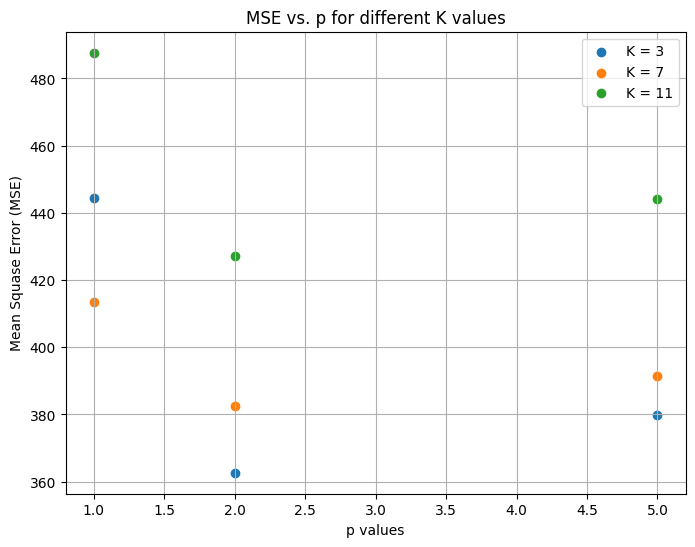

In [321]:
metrics = Metrics(k_values, p_values, mse_values_average)
best_k_avg, best_p_avg, min_mse_avg = metrics._find_best_metrics(mse_values_average)
metrics.plot_regression_metrics(mse_values_average)

In [322]:
# Regression on test set using optimal values of p, k
knn = KNN(k=best_p_avg, weight='uniform', distance_metric='minkowski', p=best_p_avg)
knn.fit_knn(X_train, y_train)
y_pred_test = knn.predict_knn(X_test)
mse_val = mean_squared_error(y_test, y_pred_test)
print(f"MSE on test set: {mse_val}")

100%|██████████| 250/250 [00:00<00:00, 273.48it/s]

MSE on test set: 414.45918841779115


**2) Weighted average of k nearest neighbors, with weights being inverse of distances from the k neighbors**

In [323]:
mse_values_distance = {} # key is `k` and the value is a list of (p, mse) tuples

for k in k_values:
    mse_k = []
    for p in p_values:
        knn = KNN(k=k, weight='distance',distance_metric='minkowski', p=p) #weights being inverse of distances
        knn.fit_knn(X_train, y_train)
        y_pred_val = knn.predict_knn(X_val)
        mse_val = mean_squared_error(y_val, y_pred_val)
        mse_k.append((p, mse_val))
    mse_values_distance[k] = mse_k

100%|██████████| 225/225 [00:01<00:00, 202.74it/s]


K = 3 and distance measure (p) = 2 gave the best performance with Mean Square Error = 349.1650785199404


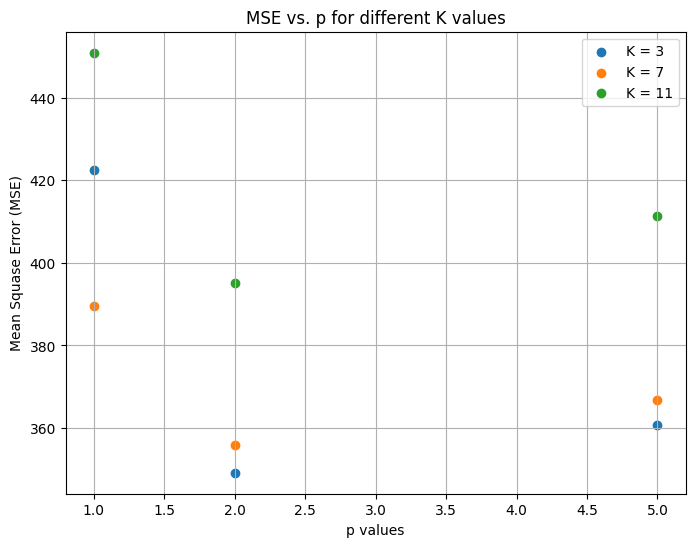

In [324]:
metrics = Metrics(k_values, p_values, mse_values_distance)
best_k_distance, best_p_distance, min_mse_distance = metrics._find_best_metrics(mse_values_distance)
metrics.plot_regression_metrics(mse_values_distance)

In [325]:
# Regression on test set using optimal values of p, k
knn = KNN(k=best_p_distance, weight='distance',distance_metric='minkowski', p=best_p_distance)
knn.fit_knn(X_train, y_train)
y_pred_test = knn.predict_knn(X_test)
mse_val = mean_squared_error(y_test, y_pred_test)
print(f"MSE on test set: {mse_val}")

100%|██████████| 250/250 [00:00<00:00, 274.64it/s]

MSE on test set: 392.2198896394537


#### Task - 4:
Implement KNN regression using scikit-learn, with the same values of k and p as above

##### Note - one argument of scikit-learn KNN is ```algorithm='auto'``` and acceptable values are ```{'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto' ```. For this task use ```'brute'``` setting.

[Marks - 4]

Answer:

*   For Average, k=3, p=2, MSE = 362.643
*   For Distance, k=3, p=2, MSE = 335.407

In [326]:
from sklearn.neighbors import KNeighborsRegressor

**1) Average of K-nearest neighbors**

In [327]:
mse_values_average_sk = {}

for k in k_values:
    mse_k = []
    for p in p_values:
        knn_regressor = KNeighborsRegressor(n_neighbors=k, weights='uniform', algorithm='brute', p=p, metric='minkowski')
        knn_regressor.fit(X_train, y_train)
        y_pred_val = knn_regressor.predict(X_val)
        mse_val = mean_squared_error(y_val, y_pred_val)
        mse_k.append((p, mse_val))
    mse_values_average_sk[k] = mse_k

In [328]:
print(mse_values_average_sk)

{3: [(2, 362.6436044358489), (1, 444.30617115634664), (5, 379.8871022423204)], 7: [(2, 382.57080433668443), (1, 413.3794484331171), (5, 391.3878085162752)], 11: [(2, 427.2328008908954), (1, 487.66790816155674), (5, 444.20338941858876)]}


K = 3 and distance measure (p) = 2 gave the best performance with Mean Square Error = 362.6436044358489


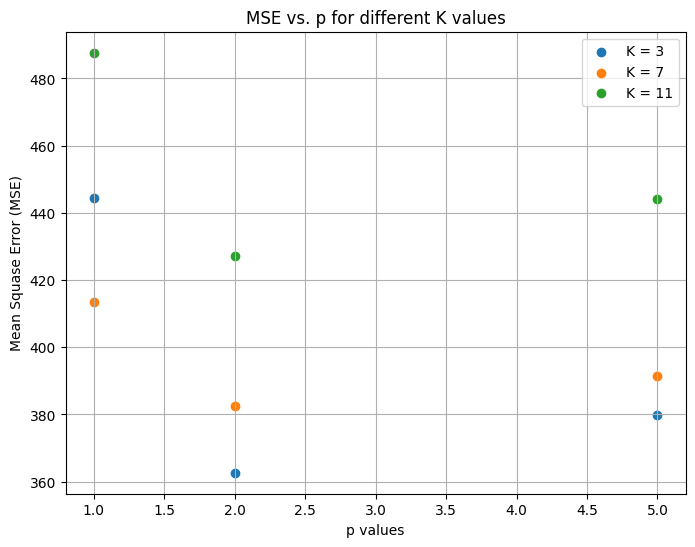

In [329]:
metrics = Metrics(k_values, p_values, mse_values_average_sk)
best_k_avg_sk, best_p_avg_sk, min_mse_avg_sk = metrics._find_best_metrics(mse_values_average_sk)
metrics.plot_regression_metrics(mse_values_average_sk)

In [330]:
# Regression on test set using optimal values of p, k
knn_regressor = KNeighborsRegressor(n_neighbors=best_k_avg_sk, weights='uniform', algorithm='brute', p=best_p_avg_sk, metric='minkowski')
knn_regressor.fit(X_train, y_train)
y_pred_test = knn_regressor.predict(X_test)
mse_val = mean_squared_error(y_test, y_pred_test)
print(f"MSE on test set: {mse_val}")

MSE on test set: 353.2350436444619


**2) Weighted average of k nearest neighbors, with weights being inverse of distances from the k neighbors**

In [331]:
mse_values_distance_sk = {}

for k in k_values:
    mse_k = []
    for p in p_values:
        knn_regressor = KNeighborsRegressor(n_neighbors=k, weights='distance',algorithm='brute', p=p, metric='minkowski')
        knn_regressor.fit(X_train, y_train)
        y_pred_val = knn_regressor.predict(X_test)
        mse_val = mean_squared_error(y_test, y_pred_val)
        mse_k.append((p, mse_val))
    mse_values_distance_sk[k] = mse_k

K = 3 and distance measure (p) = 2 gave the best performance with Mean Square Error = 335.40767518106


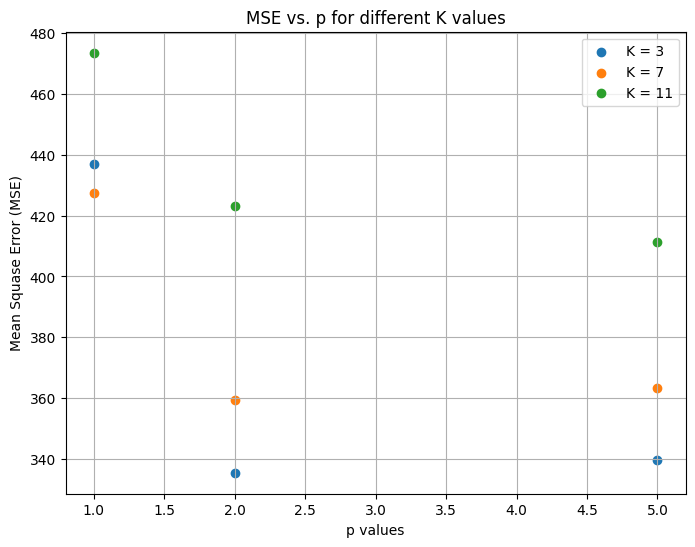

In [332]:
metrics = Metrics(k_values, p_values, mse_values_distance_sk)
best_k_distance_sk, best_p_distance_sk, min_mse_distance_sk = metrics._find_best_metrics(mse_values_distance_sk)
metrics.plot_regression_metrics(mse_values_distance_sk)

In [333]:
# Regression on test set using optimal values of p, k
knn_regressor = KNeighborsRegressor(n_neighbors=best_k_avg_sk, weights='distance', algorithm='brute', p=best_p_avg_sk, metric='minkowski')
knn_regressor.fit(X_train, y_train)
y_pred_test = knn_regressor.predict(X_test)
mse_val = mean_squared_error(y_test, y_pred_test)
print(f"MSE on test set: {mse_val}")

MSE on test set: 335.40767518106


#### Task - 5:
Comparison with scikit-learn's implementation - Does the optimal values of k and distance metric as well as best performance level of the from scratch implementation match with those given by Sklearn?

 [Marks - 2]

**1) Average of K-nearest neighbors**

Answer: k=3, p=2 (matches)

In [334]:
if best_k_avg == best_k_avg_sk and best_p_avg == best_p_avg_sk:
    print("The optimal values of k and distance metric (p) MATCH with those given by Sklearn")
    print(f"k = {best_k_distance}, p = {best_p_distance}")
else:
    print("The optimal values of k and distance metric (p) does NOT MATCH with those given by Sklearn")
    print(f"From scratch implementation, k = {best_k_distance}, p = {best_p_distance}")
    print(f"From scikit-learn implementation, k = {best_k_distance_sk}, p = {best_p_distance_sk}")

The optimal values of k and distance metric (p) MATCH with those given by Sklearn
k = 3, p = 2


**2) Weighted average of k nearest neighbors, with weights being inverse of distances from the k neighbors**

Answer: k=3, p=2 (matches)

In [335]:
if best_k_distance == best_k_distance_sk and best_p_distance == best_p_distance_sk:
    print("The optimal values of k and distance metric (p) MATCH with those given by Sklearn")
    print(f"k = {best_k_distance}, p = {best_p_distance}")
else:
    print("The optimal values of k and distance metric (p) does NOT MATCH with those given by Sklearn")
    print(f"From scratch implementation, k = {best_k_distance}, p = {best_p_distance}")
    print(f"From scikit-learn implementation, k = {best_k_distance_sk}, p = {best_p_distance_sk}")

The optimal values of k and distance metric (p) MATCH with those given by Sklearn
k = 3, p = 2
